In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot
from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from yass.augment import make
from pathlib import Path

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate
from yass.augment import util

import seaborn as sns
import pandas as pd
from dstools import plot, Env
from dstools.util import load

from keras.models import load_model

Using TensorFlow backend.


In [3]:
env = Env()

In [63]:
path_to_config = str(Path(env.project_home, 'config/gcloud/49/default.yaml'))
yass.set_config(path_to_config)
CONFIG = read_config()

path_to_standarized = Path(env.path.data, 'retinal/sample_output/preprocess/standarized.bin')

In [4]:
plt.style.use('ggplot')

In [5]:
import logging
logging.basicConfig(level=logging.INFO)

In [6]:
def predict(x, predict_function):
    # squeeze is needed for keras
    return ['{:.2f}'.format(p) for p in np.squeeze(predict_function(x))]

def shifter_generator(x, waveform_length, step):
    original_wf_length, n_channels = x.shape    
    n = int((original_wf_length - waveform_length)/step + 1)

    shifted = np.zeros((n, waveform_length, n_channels))
    
    for i in range(n):
        shifted[i, :, :] = x[(i * step):waveform_length + (i * step), :]
    
    return shifted

def predict_plot(model, x, elements=None):
    
    try:
        # old
        preds = predict(x, model.predict)
        # keras
    except:
        preds = predict(x[:, :, :, np.newaxis], model.predict_proba)

    plot.grid_from_array(x,
                         axis=0,
                         auto_figsize=3,
                         labels=preds,
                         elements=elements)


def shift_predict_plot(x, waveform_length, step, model):
    shifted = shifter_generator(x, waveform_length, step)
    predict_plot(model, shifted)

In [75]:
path_to_models = Path(env.path.data, 'triage', 'models')

# path_to_model = '
path_to_model = '/home/Edu/shengao-aug1/triage.ckpt'

model_name = '2018-08-21T00-58-18:triage-31wf7ch.h5'
path_to_model = path_to_models / model_name

metadata_path = path_to_models / model_name.replace('h5', 'yaml')

# model = NeuralNetTriage.load(path_to_model, 0.5,
#                              load_test_set=False)

# keras
# path_to_model = 'triage-31-Jul-2018@15-43-59.h5'
model = load_model(model_path)
metadata = load(metadata_path)

In [9]:
metadata

{'nb_version': '2835c5c updates',
 'path_to_x_test': '/home/Edu/data/triage/sets/2018-08-21T00-49-52:x-test-31wf7ch.npy',
 'path_to_x_train': '/home/Edu/data/triage/sets/2018-08-21T00-49-52:x-train-31wf7ch.npy',
 'path_to_y_test': '/home/Edu/data/triage/sets/2018-08-21T00-49-52:y-test-31wf7ch.npy',
 'path_to_y_train': '/home/Edu/data/triage/sets/2018-08-21T00-49-52:y-train-31wf7ch.npy',
 'yass_version': 'f6dd519 removing split'}

In [15]:
data = {k.replace('path_to_', ''): load(v) for k, v in metadata.items() if k.startswith('path')}

In [16]:
data.keys()

dict_keys(['x_test', 'x_train', 'y_test', 'y_train'])

## Evaluation on test set

In [38]:
x_test = data['x_test']
x_train = data['x_train']

y_test = data['y_test'].astype(int)
y_train = data['y_train'].astype(int)

In [39]:
y_pred = np.squeeze(model.predict_classes(data['x_test'][:, :, :, np.newaxis]))
y_true = y_test

print(metrics.classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11782
          1       1.00      1.00      1.00     11978

avg / total       1.00      1.00      1.00     23760



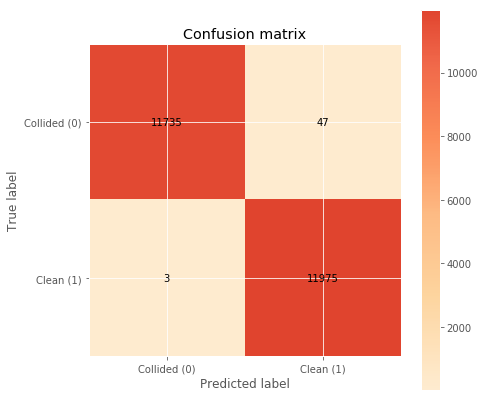

In [40]:
plt.rcParams['figure.figsize'] = (7, 7)
sk_plot.confusion_matrix(y_true, y_pred,
                         target_names=['Collided (0)', 'Clean (1)'],
                         normalize=False)

In [41]:
_ = metrics.confusion_matrix(y_true, y_pred)
cm = _ / _.sum(axis=1)
tn, fp, fn, tp = cm.flatten()
tn, fp, fn, tp

(0.996010864029876,
 0.003923860410753047,
 0.00025462570022067563,
 0.9997495408248456)

In [42]:
metrics.accuracy_score(y_true, y_pred)

0.997895622895623

In [43]:
metrics.f1_score(y_true, y_pred)

0.9979166666666668

In [44]:
metrics.recall_score(y_true, y_pred)

0.9997495408248456

In [45]:
metrics.precision_score(y_true, y_pred)

0.9960905007486275

In [46]:
clean = x_test[y_test == 1]
collided = x_test[y_test == 0]

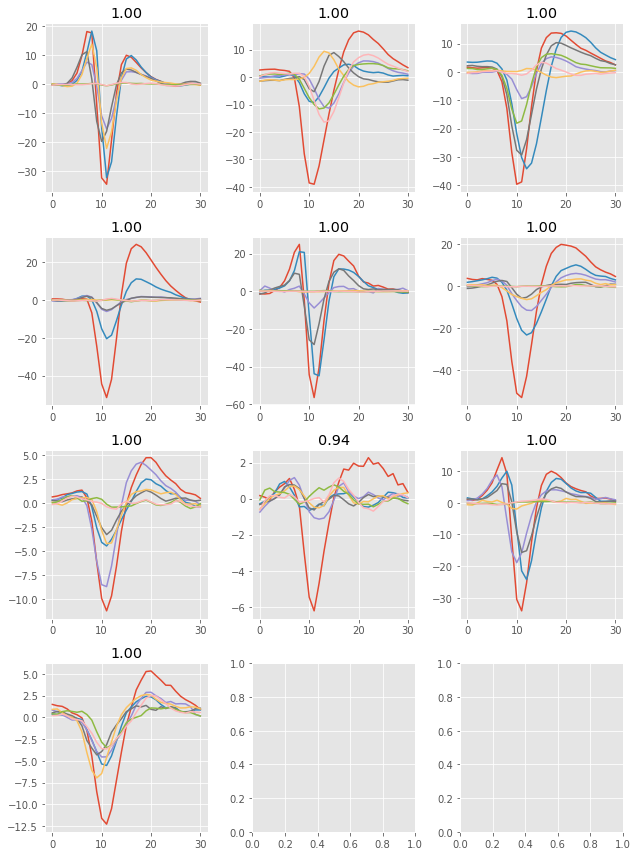

In [47]:
predict_plot(model, clean, elements=10)

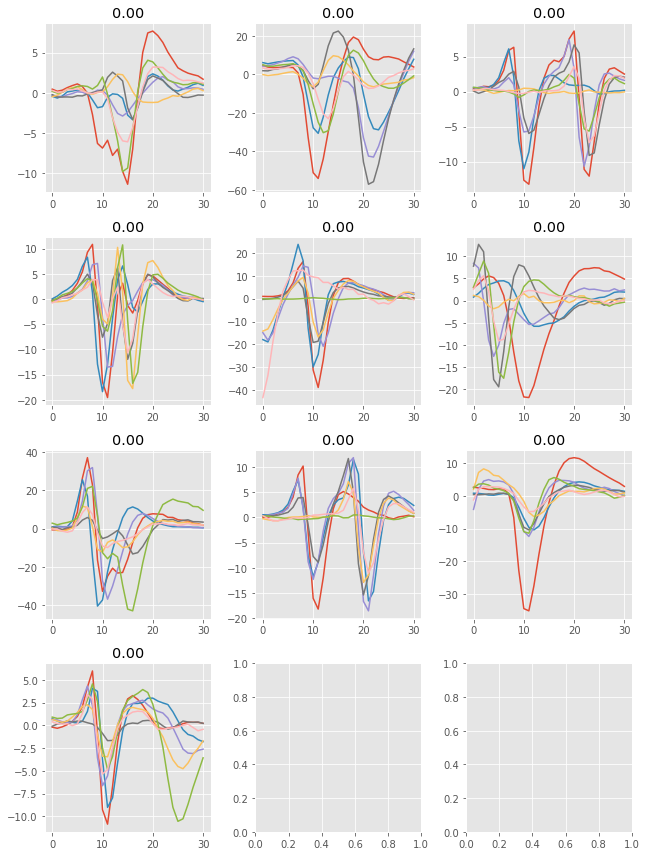

In [48]:
predict_plot(model, collided, elements=10)

## Generate data for evaluation

In [49]:
raw_templates = np.load(Path(env.path.data, 'cat/templates-jul27-only-good.npy'))
_, waveform_length, _ = raw_templates.shape
print(raw_templates.shape)

(240, 61, 49)


In [55]:
# crop spatially
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .crop_temporally(15)
            .values)
templates.shape

(240, 31, 7)

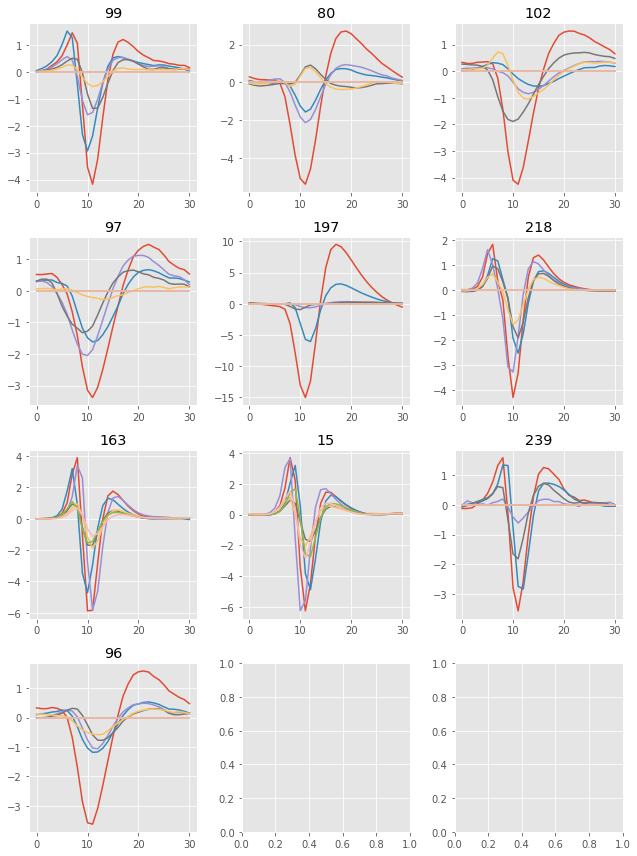

In [56]:
plot.grid_from_array(templates, axis=0, max_cols=3,
                     auto_figsize=3, elements=10)

In [57]:
templates.shape

(240, 31, 7)

In [66]:
min_amp = 3
max_amp = 20
min_shift = 4
n_clean_per_template = 40

In [67]:
dataset = Dataset.make(units_per_bin=1,
                       include_clean_data=False,
                       templates=templates,
                       min_amplitude=min_amp,
                       max_amplitude=max_amp,
                       path_to_data=path_to_standarized,
                       n_per_template=n_clean_per_template,
                       geom=CONFIG.geom,
                       min_shift=min_shift,
                       make_from_templates=True,
                       make_spatially_misaligned=False,
                       make_temporally_misaligned=False,
                       make_collided=True,
                       make_noise=False,
                       return_metadata=True)

In [68]:
from_templates = dataset.get_kind('from templates').data
collided = dataset.get_kind('collided').data

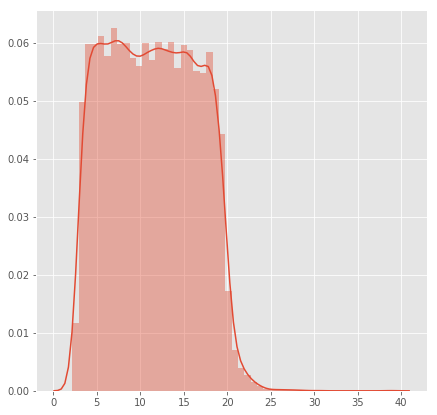

In [69]:
sns.distplot(dataset.amplitudes)

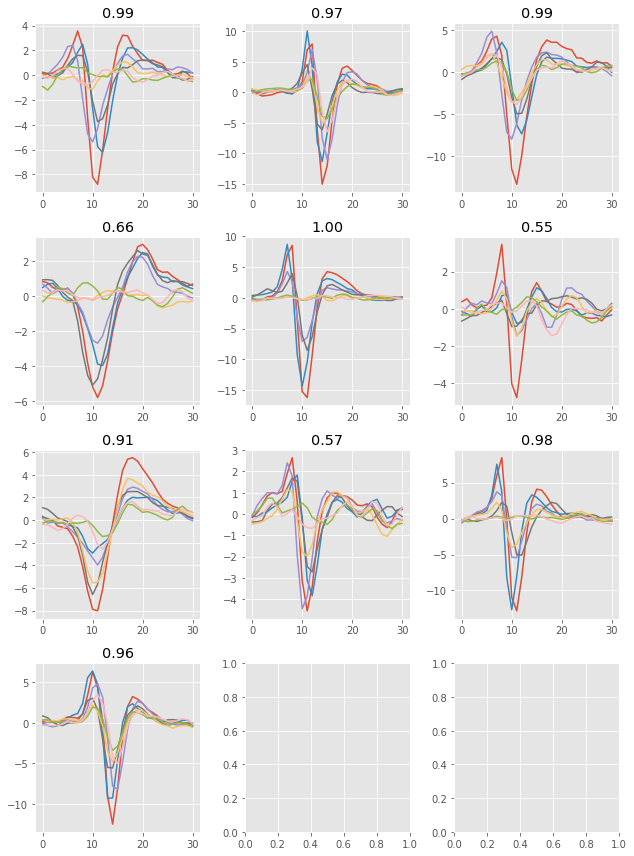

In [70]:
predict_plot(model, from_templates, 10)

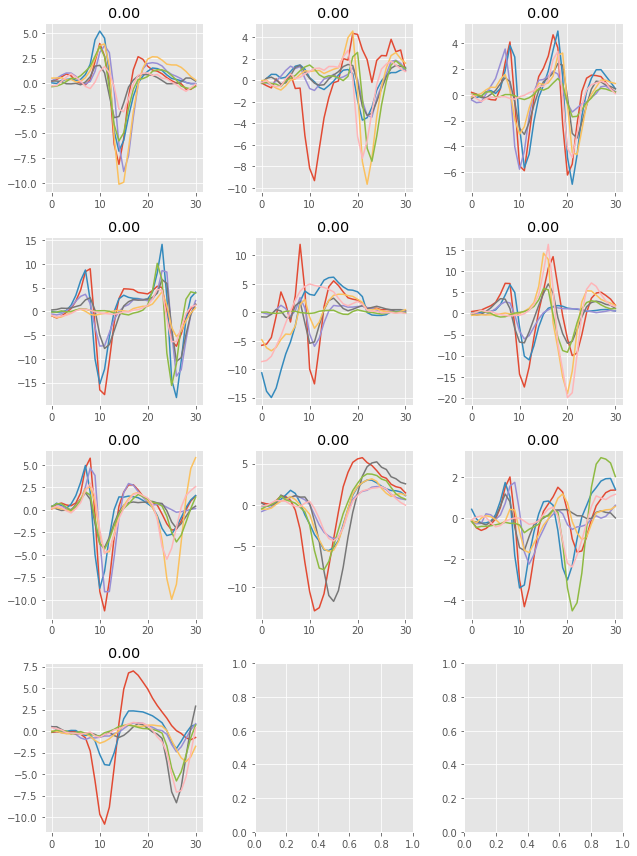

In [71]:
predict_plot(model, collided, 10)

In [72]:
_ = util.make_collided(dataset.get_kind('from templates').data,
                       n_per_spike=1, multi_channel=True,
                       return_metadata=True)

collided = util.add_noise(_.array, dataset.spatial_sig,
                          dataset.temporal_sig)
collided_metadata = _.metadata

TypeError: make_collided() missing 1 required positional argument: 'min_shift'

In [24]:
# preds = predict(collided[:, :, :, np.newaxis], model.predict_proba)
preds = predict(collided, model.predict)

labels = ['P(clean)={} shift={}'.format(p, s)
          for p, s in zip(preds, collided_metadata['shift'])]

In [25]:
def shift_waveform(x, shift):

    wf_length, _, = x.shape
    zeros = np.zeros(x.shape)
    
    if shift > 0:
        zeros[:(wf_length-shift)] += x[shift:]
        return zeros
    elif shift < 0:
        zeros[(-shift):] += x[:(wf_length+shift)]
        return zeros
    else:
        return x

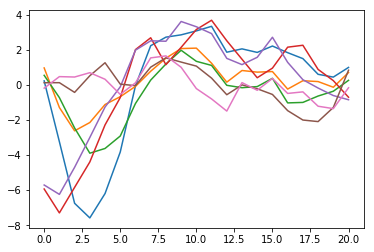

In [26]:
s = collided_metadata['first'][0]
_ = plt.plot(s)

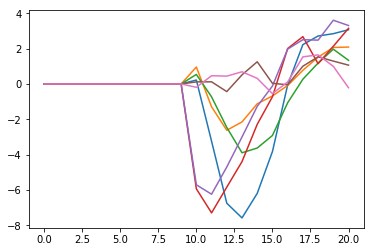

In [27]:
_ = plt.plot(shift_waveform(s, -10))

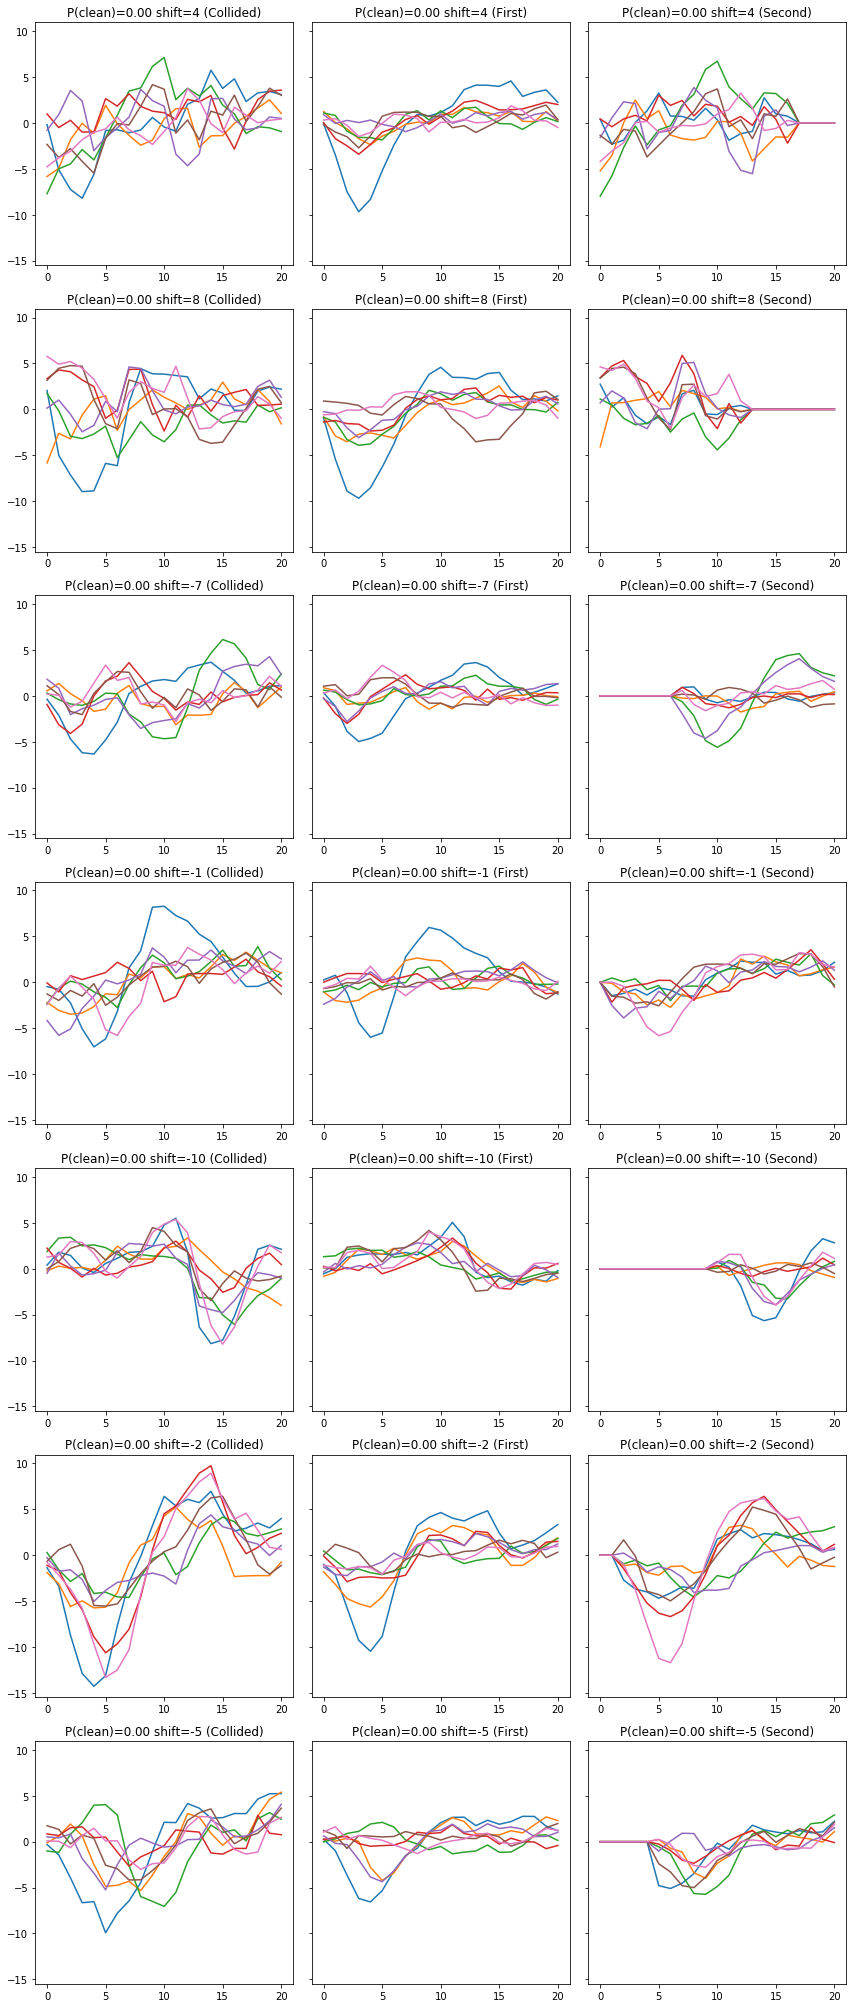

In [28]:
to_plot = [collided, collided_metadata['first'],
           collided_metadata['second']]

plot.grid_from_array(to_plot,
             axis=0,
             elements=7,
             group_names=('Collided', 'First', 'Second'),
             labels=labels,
             auto_figsize=4,
             sharey=True)

## Metrics for different SNR

In [91]:
THRESHOLD = 0.7

In [77]:
def process_group(group_id, group, predict_function, metric_fn):
    """Process a single group in a dataframe
    """
    # get waveforms
    wfs = np.stack(group.waveform.values, axis=0)
    
    # make predictions
    try:
        preds = predict_function(wfs)
    except:
        # keras
        preds = np.squeeze(predict_function(wfs[:, :, :, np.newaxis]))
    
    # compute metric
    metric = metric_fn(preds, group)

    return group_id, metric

def compute_per_group(df, column, predict_function, metric_fn):
    """Compute a metric over groups in a dataframe
    """
    # group and compute proportion of correct predictions
    vals = [process_group(group_id, group, predict_function, metric_fn)
            for group_id, group
            in df.groupby(column)]

    group_ids, metric = list(zip(*vals))

    return group_ids, metric

In [78]:
dataset.stats

{'from templates': 9600, 'collided': 9600}

In [79]:
# df = dataset.get_kind('collided').df
df = dataset.df

# add labels
_ = {'from templates': 1, 'collided': 0}

df['label'] = df.kind.replace(_)

df.head()

,waveform,amplitude,kind,ptp,amplitude_group,ptp_group,label
0,"[[-0.17489707236791918, -0.7640408650427134, -...",3.499374,from templates,5.243175,3.814,5.244,1
1,"[[0.282854785156349, -0.3984066474444355, 0.08...",3.629917,from templates,5.195894,3.814,5.244,1
2,"[[0.4177507698575078, 0.1330628018095535, 0.17...",3.807423,from templates,5.858985,3.814,6.138,1
3,"[[0.5050473739209798, 0.040376275540102424, 0....",4.270655,from templates,6.076292,4.287,6.138,1
4,"[[0.39489196038076446, 0.5763783013934236, 0.1...",4.367657,from templates,6.074207,4.738,6.138,1


In [80]:
def mean_tp_prob(preds, group):
    real_ones = group.label.values == 1
    return preds[real_ones].mean()

def mean_tn_prob(preds, group):
    real_zeros = group.label.values == 0
    return preds[real_zeros].mean()

def acc(preds, group):
    return (preds == group.label.values).mean()

def fpr(preds, group):
    real_zeros = group.label.values == 0
    return (preds[real_zeros] == 1).mean()

def fnr(preds, group):
    real_ones = group.label.values == 1
    return (preds[real_ones] == 0).mean()

In [92]:
from functools import partial

def predict_w_threshold(x, threshold):
    return model.predict_proba(x) > threshold

predict_ = partial(predict_w_threshold, threshold=THRESHOLD)

In [51]:
# FIXME: checking dimensions
# model_ref.predict(df.iloc[0].waveform[np.newaxis, :10, :])

In [95]:
ax

AttributeError: module 'matplotlib.pyplot' has no attribute 'ax'

In [114]:
def plot_metric(metric, title, ax=None, **kwargs):
#     plt.figure(figsize=(20, 10))
    
    if ax is None:
        ax = plt.gca()
    
    x, y = compute_per_group(df,
                         'amplitude_group',
                         predict_, metric)
    
#     x_ref, y_ref = compute_per_group(df,
#                          'amplitude_group',
#                          predict_,
#                          metric)

#     min_ = np.min(x)
#     max_ = np.max(x)


    plt.figure(figsize=(20, 10))

    _ = ax.scatter(x, y, **kwargs)
#     _ = plt.scatter(x_ref, y_ref, color='r', label='Triage reference')

    # _ = plt.hlines(1.0, 2, max_, linestyles='dashed')
    # _ = plt.hlines(0.98, 2, max_, linestyles='dashed')
    # _ = plt.hlines(0.9, 2, max_, linestyles='dashed')
    # _ = plt.vlines(2.5, 0.5, 1, linestyles='dashed')

#     _ = ax.xlim(2, 20)
#     _ = ax.set_title(title)

    _ = ax.legend()
#     _ = ax.set_xticks(rotation=45)
    
    return ax

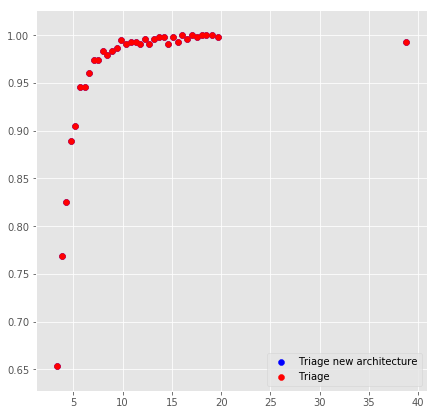

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [115]:
ax = plot_metric(acc, title='Triage network - Amplitude vs accuracy', color='b', label='Triage new architecture')
plot_metric(acc, title='Triage network - Amplitude vs accuracy', color='r', label='Triage',
            ax=ax)